**1. Persiapan Lingkungan & Ekstraksi Data**

In [ ]:
# Cek GPU
import tensorflow as tf
print("GPU:", tf.config.list_physical_devices('GPU'))


GPU: []


In [ ]:
import zipfile
import os

zip_path = "Datasets\Makanan Indonesia.zip"  
extract_path = "Datasets"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Isi folder:", os.listdir(extract_path))


Isi folder: ['makan']


**2. Setup Folder Train & Parameter Augmentasi**

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tqdm import tqdm

train_dir = "Datasets\\makan\\train"
target_per_class = 1000
img_size = (224, 224)


Augmentasi yang dipakai

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)


NameError: name 'ImageDataGenerator' is not defined

In [ ]:
from tensorflow.keras import models, layers

data_augmentation = models.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [ ]:
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    num_images = len(images)

    print(f"\nKelas: {class_name} ")
    print(f"Jumlah awal: 500")

    if num_images >= target_per_class:
        print("Sudah mencukupi, skip.")
        continue

    augment_needed = target_per_class - num_images
    generated = 0

    with tqdm(total=augment_needed) as pbar:
        while generated < augment_needed:
            for img_name in images:
                if generated >= augment_needed:
                    break

                img_path = os.path.join(class_path, img_name)

                img = load_img(img_path, target_size=img_size)
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)

                for batch in datagen.flow(
                    x,
                    batch_size=1,
                    save_to_dir=class_path,
                    save_prefix="aug",
                    save_format="jpg"
                ):
                    generated += 1
                    pbar.update(1)
                    break

    print(f"Total akhir kelas {class_name}: {len(os.listdir(class_path))}")



Kelas:  
Jumlah awal: 500


  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [00:30<00:00, 19.44it/s]


Total akhir kelas Gado-Gado: 981

Kelas:  
Jumlah awal: 500


100%|██████████| 600/600 [00:31<00:00, 18.91it/s]


Total akhir kelas Nasi Goreng: 976

Kelas:  
Jumlah awal: 500


100%|██████████| 600/600 [00:26<00:00, 22.77it/s]


Total akhir kelas Nasi Padang: 986

Kelas:  
Jumlah awal: 500


100%|██████████| 600/600 [00:20<00:00, 29.10it/s]


Total akhir kelas Rendang: 979

Kelas:  
Jumlah awal: 500


100%|██████████| 600/600 [00:17<00:00, 34.29it/s]

Total akhir kelas Sate: 987


# **IMPLEMENTASI MODEL**

Data Preparation

In [ ]:
import os
import tensorflow as tf

IMG_SIZE = (160, 160)
BATCH_SIZE = 32
DATASET_PATH = "makan"

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "valid"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

Found 4909 files belonging to 5 classes.
Found 250 files belonging to 5 classes.
Found 250 files belonging to 5 classes.


Model 1 — CNN Base (Non-Pretrained)1.

In [ ]:
cnn_base = models.Sequential([
    data_augmentation,

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')
])

cnn_base.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_cnn = cnn_base.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 94s 573ms/step - accuracy: 0.3822 - loss: 1.3883 - val_accuracy: 0.4120 - val_loss: 1.3176
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 79s 515ms/step - accuracy: 0.5076 - loss: 1.1653 - val_accuracy: 0.5400 - val_loss: 1.0876
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 57s 368ms/step - accuracy: 0.5663 - loss: 1.0758 - val_accuracy: 0.6800 - val_loss: 0.8896
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 50s 324ms/step - accuracy: 0.6128 - loss: 0.9774 - val_accuracy: 0.6600 - val_loss: 0.8450
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 50s 325ms/step - accuracy: 0.6513 - loss: 0.8850 - val_accuracy: 0.7200 - val_loss: 0.7389
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 50s 327ms/step - accuracy: 0.6779 - loss: 0.8250 - val_accuracy: 0.6640 - val_loss: 0.8046
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 51s 331ms/step - accuracy: 0.7132 - loss: 0.7617 - val_accuracy: 0.6880 - val_loss: 0.7646
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 49s 320ms/step - accuracy: 0.7346 - loss: 0

Model 2 — Transfer Learning (MobileNetV2)

In [ ]:
import tensorflow as tf

IMG_SIZE = (160, 160)
NUM_CLASSES = 5


# INPUT

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))

# PREPROCESSING (ON-THE-FLY)

x = tf.keras.layers.Rescaling(1./255)(inputs)
x = tf.keras.layers.RandomFlip("horizontal")(x)
x = tf.keras.layers.RandomRotation(0.1)(x)
x = tf.keras.layers.RandomZoom(0.1)(x)


# BASE MODEL

base_mobilenet = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_tensor=x
)

base_mobilenet.trainable = False  # WAJIB untuk transfer learning awal


# CLASSIFIER

x = base_mobilenet.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(
    NUM_CLASSES,
    activation="softmax"
)(x)


# MODEL

model_mobilenet = tf.keras.Model(inputs, outputs)

model_mobilenet.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_mobilenet.summary()


history_mobilenet = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


C:\Users\Win10\AppData\Local\Temp\ipykernel_16028\902845278.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_mobilenet = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 160, 160,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_1       │ (None, 160, 160,  │          0 │ rescaling_1[0][0] │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_1   │ (None, 160, 160,  │          0 │ random_flip_1[0]… │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom_1       │ (None, 160, 160,  │          0 │ random_rotation_… │
│ (RandomZoom)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ random_zoom_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 68s 409ms/step - accuracy: 0.6997 - loss: 0.8304 - val_accuracy: 0.8680 - val_loss: 0.4556
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 58s 375ms/step - accuracy: 0.8220 - loss: 0.5167 - val_accuracy: 0.8760 - val_loss: 0.3859
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 56s 365ms/step - accuracy: 0.8440 - loss: 0.4455 - val_accuracy: 0.9040 - val_loss: 0.3397
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 54s 351ms/step - accuracy: 0.8605 - loss: 0.4062 - val_accuracy: 0.8680 - val_loss: 0.3440
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 54s 352ms/step - accuracy: 0.8751 - loss: 0.3675 - val_accuracy: 0.8960 - val_loss: 0.3317
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 54s 350ms/step - accuracy: 0.8755 - loss: 0.3487 - val_accuracy: 0.9000 - val_loss: 0.3606
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 54s 349ms/step - accuracy: 0.8918 - loss: 0.3050 - val_accuracy: 0.9080 - val_loss: 0.3463
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 56s 365ms/step - accuracy: 0.8951 - loss: 0

Model 3 — Transfer Learning (ResNet50)

In [ ]:
inputs = tf.keras.Input(shape=(160,160,3))

x = tf.keras.layers.Rescaling(1./255)(inputs)
x = tf.keras.layers.RandomFlip("horizontal")(x)
x = tf.keras.layers.RandomRotation(0.1)(x)

base_resnet = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_tensor=x
)

base_resnet.trainable = False

x = base_resnet.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model_resnet = tf.keras.Model(inputs, outputs)

model_resnet.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 113s 698ms/step - accuracy: 0.2573 - loss: 1.6106 - val_accuracy: 0.4000 - val_loss: 1.5203
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 104s 677ms/step - accuracy: 0.3035 - loss: 1.5346 - val_accuracy: 0.4000 - val_loss: 1.4765
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 104s 672ms/step - accuracy: 0.3192 - loss: 1.5062 - val_accuracy: 0.4200 - val_loss: 1.4382
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 103s 670ms/step - accuracy: 0.3388 - loss: 1.4915 - val_accuracy: 0.4240 - val_loss: 1.4330
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 104s 675ms/step - accuracy: 0.3451 - loss: 1.4797 - val_accuracy: 0.4040 - val_loss: 1.4221
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 104s 674ms/step - accuracy: 0.3595 - loss: 1.4646 - val_accuracy: 0.4480 - val_loss: 1.3981
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 101s 656ms/step - accuracy: 0.3593 - loss: 1.4642 - val_accuracy: 0.4240 - val_loss: 1.4002
Epoch 8/10
154/154 ━━━━━━

# **EVALUASI & ANALISIS MODEL**

Classification Report & Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt # Import matplotlib

def evaluate_model(model, name):
    y_pred = np.argmax(model.predict(test_ds), axis=1)
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_true = np.argmax(y_true, axis=1)

    print(f"\n📊 {name}")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(name)
    plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step

📊 CNN Base
              precision    recall  f1-score   support

   Gado-Gado       0.71      0.80      0.75        50
 Nasi Goreng       0.59      0.94      0.73        50
 Nasi Padang       0.82      0.62      0.70        50
     Rendang       0.78      0.70      0.74        50
        Sate       0.81      0.52      0.63        50

    accuracy                           0.72       250
   macro avg       0.74      0.72      0.71       250
weighted avg       0.74      0.72      0.71       250



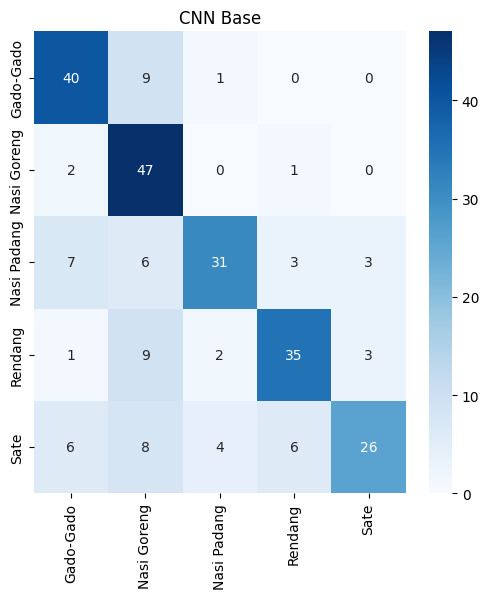

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 425ms/step

📊 MobileNetV2
              precision    recall  f1-score   support

   Gado-Gado       0.87      0.92      0.89        50
 Nasi Goreng       0.94      0.88      0.91        50
 Nasi Padang       0.98      0.82      0.89        50
     Rendang       0.96      0.92      0.94        50
        Sate       0.80      0.96      0.87        50

    accuracy                           0.90       250
   macro avg       0.91      0.90      0.90       250
weighted avg       0.91      0.90      0.90       250



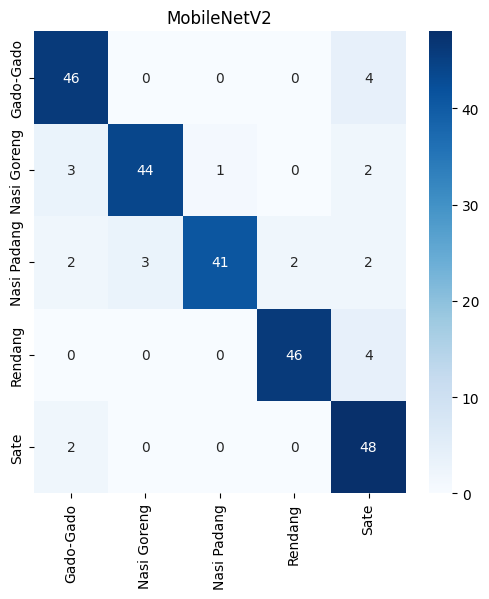

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 875ms/step

📊 ResNet50
              precision    recall  f1-score   support

   Gado-Gado       0.37      0.80      0.50        50
 Nasi Goreng       0.50      0.20      0.29        50
 Nasi Padang       0.59      0.52      0.55        50
     Rendang       0.52      0.46      0.49        50
        Sate       0.36      0.24      0.29        50

    accuracy                           0.44       250
   macro avg       0.47      0.44      0.42       250
weighted avg       0.47      0.44      0.42       250



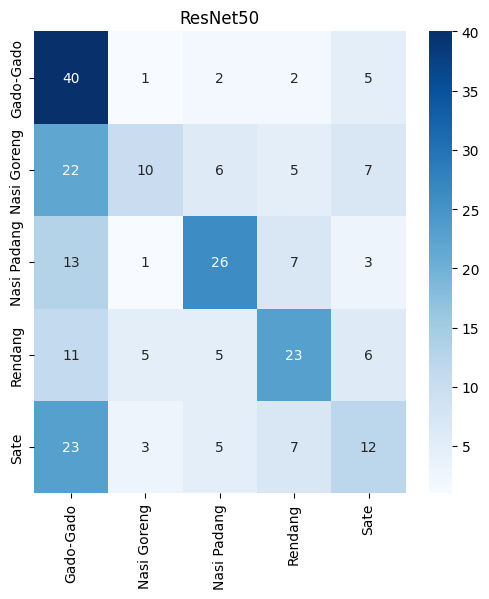

In [ ]:
evaluate_model(cnn_base, "CNN Base")
evaluate_model(model_mobilenet, "MobileNetV2")
evaluate_model(model_resnet, "ResNet50")


Grafik Accuracy & Loss

In [ ]:
def plot_history(history, title):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Accuracy - {title}')
    plt.legend(['Train','Val'])

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Loss - {title}')
    plt.legend(['Train','Val'])

    plt.show()

# Untuk menampilkan grafik, panggil fungsi plot_history setelah setiap model dilatih, contoh:
plot_history(history_cnn, "CNN Base")
plot_history(history_mobilenet, "MobileNetV2")
plot_history(history_resnet, "ResNet50")
# Pastikan variabel history_cnn, history_mobilenet, dan history_resnet sudah didefinisikan.

Simpan Model


In [ ]:
cnn_base.save("cnn_base.h5")
model_mobilenet.save("mobilenet.h5")
model_resnet.save("resnet.h5")
